In [1]:
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("hf://datasets/scikit-learn/adult-census-income/adult.csv")

df = df[['age', 'workclass', 'education', 'education.num', 'marital.status',
         'occupation', 'relationship', 'race', 'sex', 'capital.gain',
         'capital.loss', 'hours.per.week', 'native.country', 'income']]

df = pd.get_dummies(df, columns=['workclass', 'education', 'marital.status',
                                 'occupation', 'relationship', 'race', 'native.country', 'sex'], drop_first=True)

df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

y = df['income']
X = df.drop(columns=['income'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_mlp(X_train.shape[1])
print("Model training...")
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))
print("Model training completed!")

Model training...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


814/814 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7895 - loss: 0.4328 - val_accuracy: 0.8455 - val_loss: 0.3318
Epoch 2/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8452 - loss: 0.3305 - val_accuracy: 0.8489 - val_loss: 0.3250
Epoch 3/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8552 - loss: 0.3147 - val_accuracy: 0.8481 - val_loss: 0.3226
Epoch 4/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8515 - loss: 0.3195 - val_accuracy: 0.8471 - val_loss: 0.3248
Epoch 5/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8523 - loss: 0.3145 - val_accuracy: 0.8486 - val_loss: 0.3189
Epoch 6/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8615 - loss: 0.3003 - val_accuracy: 0.8508 - val_loss: 0.3164
Epoch 7/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8594 - loss: 0.3011 - val_accuracy: 0.8518 - val_loss: 0.3171
Epoch 8/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8629 - loss: 0.2994 - val_accuracy: 0.8503 - val_

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.182e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.502e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.398e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2

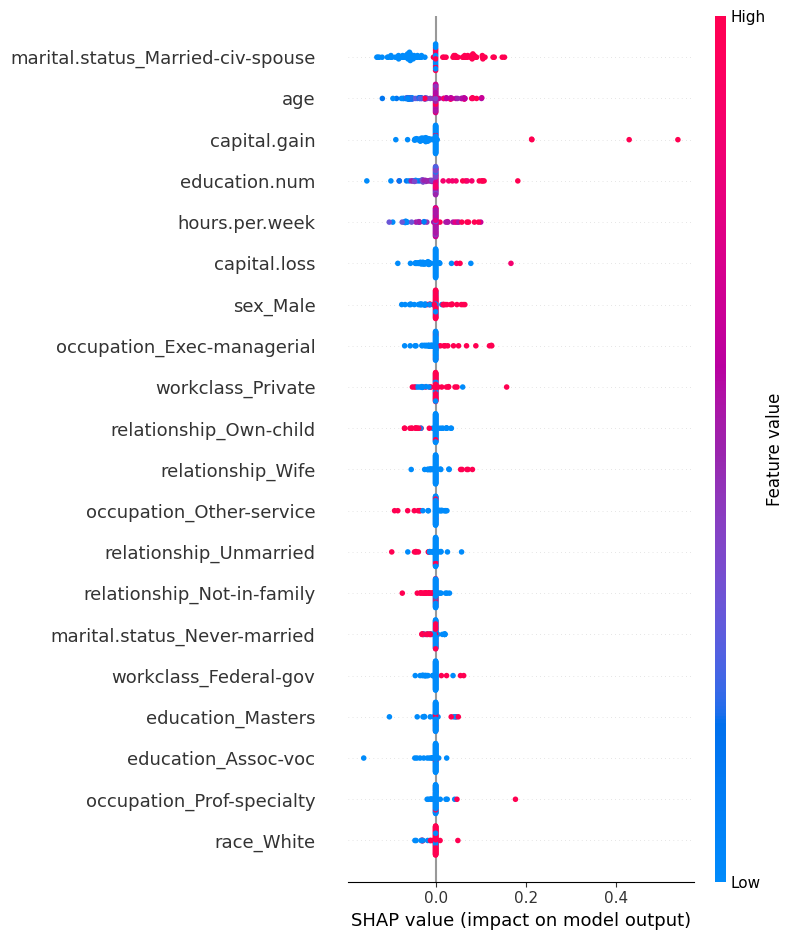

In [4]:
def predict_fn(X_numpy):
    return model(X_numpy, training=False).numpy().flatten()

explainer = shap.KernelExplainer(predict_fn, X_train_scaled[:50])
shap_values = explainer.shap_values(X_test_scaled[:100], nsamples=50)

shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=X.columns)

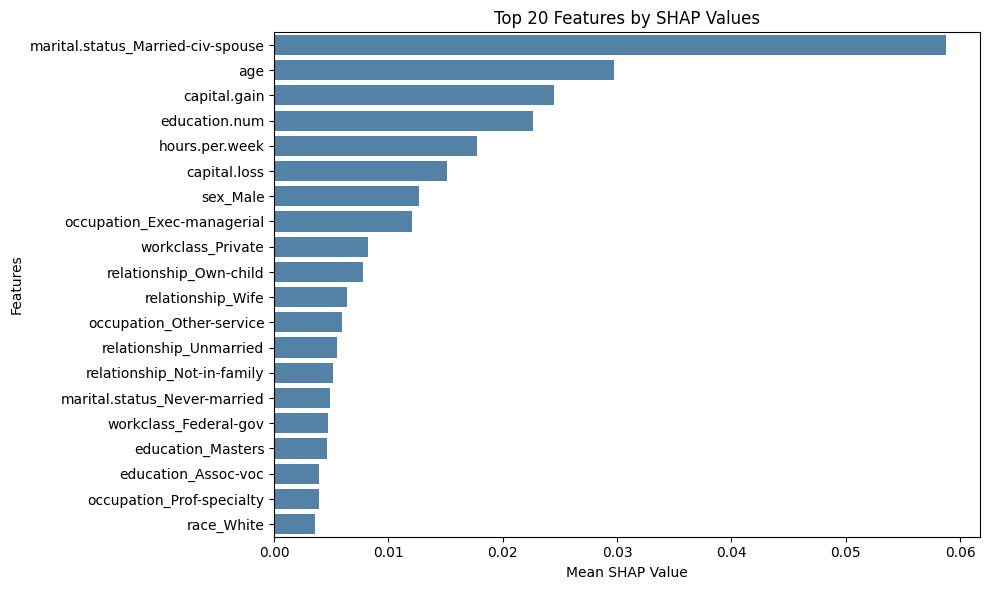


SHAP Table (Top Features):


,Features,Mean SHAP Value
29,marital.status_Married-civ-spouse,0.058801
0,age,0.029686
2,capital.gain,0.024474
1,education.num,0.022630
4,hours.per.week,0.017700
3,capital.loss,0.015153
98,sex_Male,0.012677
37,occupation_Exec-managerial,0.012019
8,workclass_Private,0.008230
50,relationship_Own-child,0.007742


In [5]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
df_importance = pd.DataFrame({'Features': X.columns, 'Mean SHAP Value': mean_abs_shap})
df_importance = df_importance.sort_values('Mean SHAP Value', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='Features', x='Mean SHAP Value', data=df_importance.head(20), color='steelblue')
plt.title("Top 20 Features by SHAP Values")
plt.xlabel("Mean SHAP Value")
plt.tight_layout()
plt.show()

print("\nSHAP Table (Top Features):")
display(df_importance.head(20))